# AutoML for Multilayer Perceptron

E2E classification example using autoML methods for optimizing hyperparameters and model architectures.

Deep learning works best on very large datasets, but that is not convenient for a quick introduction to the syntax.  So in this workbook we use the well known iris data set from https://archive.ics.uci.edu/ml/datasets/iris to help get you started.  It is similar to the example in user docs http://madlib.apache.org/docs/latest/index.html

For more realistic examples please refer to the deep learning notebooks at
https://github.com/apache/madlib-site/tree/asf-site/community-artifacts

## Table of contents

<a href="#create_input_data">1. Create input data</a>

<a href="#pp">2. Call preprocessor for deep learning</a>

<a href="#load">3. Define and load model architecture</a>

<a href="#hyperband">4. Hyperband</a>

<a href="#hyperopt">5. Hyperopt</a>

<a href="#pred">6. Predict</a>

In [1]:
%load_ext sql

In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.18.0-dev, git revision: rel/v1.17.0-89-g14a91ce, cmake configuration time: Fri Mar 5 23:08:38 UTC 2021, build type: release, build system: Linux-3.10.0-1160.11.1.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


<a id="class"></a>
# Classification

<a id="create_input_data"></a>
# 1.  Create input data

Load iris data set.

In [4]:
%%sql 
DROP TABLE IF EXISTS iris_data;

CREATE TABLE iris_data(
    id serial,
    attributes numeric[],
    class_text varchar
);

INSERT INTO iris_data(id, attributes, class_text) VALUES
(1,ARRAY[5.1,3.5,1.4,0.2],'Iris-setosa'),
(2,ARRAY[4.9,3.0,1.4,0.2],'Iris-setosa'),
(3,ARRAY[4.7,3.2,1.3,0.2],'Iris-setosa'),
(4,ARRAY[4.6,3.1,1.5,0.2],'Iris-setosa'),
(5,ARRAY[5.0,3.6,1.4,0.2],'Iris-setosa'),
(6,ARRAY[5.4,3.9,1.7,0.4],'Iris-setosa'),
(7,ARRAY[4.6,3.4,1.4,0.3],'Iris-setosa'),
(8,ARRAY[5.0,3.4,1.5,0.2],'Iris-setosa'),
(9,ARRAY[4.4,2.9,1.4,0.2],'Iris-setosa'),
(10,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(11,ARRAY[5.4,3.7,1.5,0.2],'Iris-setosa'),
(12,ARRAY[4.8,3.4,1.6,0.2],'Iris-setosa'),
(13,ARRAY[4.8,3.0,1.4,0.1],'Iris-setosa'),
(14,ARRAY[4.3,3.0,1.1,0.1],'Iris-setosa'),
(15,ARRAY[5.8,4.0,1.2,0.2],'Iris-setosa'),
(16,ARRAY[5.7,4.4,1.5,0.4],'Iris-setosa'),
(17,ARRAY[5.4,3.9,1.3,0.4],'Iris-setosa'),
(18,ARRAY[5.1,3.5,1.4,0.3],'Iris-setosa'),
(19,ARRAY[5.7,3.8,1.7,0.3],'Iris-setosa'),
(20,ARRAY[5.1,3.8,1.5,0.3],'Iris-setosa'),
(21,ARRAY[5.4,3.4,1.7,0.2],'Iris-setosa'),
(22,ARRAY[5.1,3.7,1.5,0.4],'Iris-setosa'),
(23,ARRAY[4.6,3.6,1.0,0.2],'Iris-setosa'),
(24,ARRAY[5.1,3.3,1.7,0.5],'Iris-setosa'),
(25,ARRAY[4.8,3.4,1.9,0.2],'Iris-setosa'),
(26,ARRAY[5.0,3.0,1.6,0.2],'Iris-setosa'),
(27,ARRAY[5.0,3.4,1.6,0.4],'Iris-setosa'),
(28,ARRAY[5.2,3.5,1.5,0.2],'Iris-setosa'),
(29,ARRAY[5.2,3.4,1.4,0.2],'Iris-setosa'),
(30,ARRAY[4.7,3.2,1.6,0.2],'Iris-setosa'),
(31,ARRAY[4.8,3.1,1.6,0.2],'Iris-setosa'),
(32,ARRAY[5.4,3.4,1.5,0.4],'Iris-setosa'),
(33,ARRAY[5.2,4.1,1.5,0.1],'Iris-setosa'),
(34,ARRAY[5.5,4.2,1.4,0.2],'Iris-setosa'),
(35,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(36,ARRAY[5.0,3.2,1.2,0.2],'Iris-setosa'),
(37,ARRAY[5.5,3.5,1.3,0.2],'Iris-setosa'),
(38,ARRAY[4.9,3.1,1.5,0.1],'Iris-setosa'),
(39,ARRAY[4.4,3.0,1.3,0.2],'Iris-setosa'),
(40,ARRAY[5.1,3.4,1.5,0.2],'Iris-setosa'),
(41,ARRAY[5.0,3.5,1.3,0.3],'Iris-setosa'),
(42,ARRAY[4.5,2.3,1.3,0.3],'Iris-setosa'),
(43,ARRAY[4.4,3.2,1.3,0.2],'Iris-setosa'),
(44,ARRAY[5.0,3.5,1.6,0.6],'Iris-setosa'),
(45,ARRAY[5.1,3.8,1.9,0.4],'Iris-setosa'),
(46,ARRAY[4.8,3.0,1.4,0.3],'Iris-setosa'),
(47,ARRAY[5.1,3.8,1.6,0.2],'Iris-setosa'),
(48,ARRAY[4.6,3.2,1.4,0.2],'Iris-setosa'),
(49,ARRAY[5.3,3.7,1.5,0.2],'Iris-setosa'),
(50,ARRAY[5.0,3.3,1.4,0.2],'Iris-setosa'),
(51,ARRAY[7.0,3.2,4.7,1.4],'Iris-versicolor'),
(52,ARRAY[6.4,3.2,4.5,1.5],'Iris-versicolor'),
(53,ARRAY[6.9,3.1,4.9,1.5],'Iris-versicolor'),
(54,ARRAY[5.5,2.3,4.0,1.3],'Iris-versicolor'),
(55,ARRAY[6.5,2.8,4.6,1.5],'Iris-versicolor'),
(56,ARRAY[5.7,2.8,4.5,1.3],'Iris-versicolor'),
(57,ARRAY[6.3,3.3,4.7,1.6],'Iris-versicolor'),
(58,ARRAY[4.9,2.4,3.3,1.0],'Iris-versicolor'),
(59,ARRAY[6.6,2.9,4.6,1.3],'Iris-versicolor'),
(60,ARRAY[5.2,2.7,3.9,1.4],'Iris-versicolor'),
(61,ARRAY[5.0,2.0,3.5,1.0],'Iris-versicolor'),
(62,ARRAY[5.9,3.0,4.2,1.5],'Iris-versicolor'),
(63,ARRAY[6.0,2.2,4.0,1.0],'Iris-versicolor'),
(64,ARRAY[6.1,2.9,4.7,1.4],'Iris-versicolor'),
(65,ARRAY[5.6,2.9,3.6,1.3],'Iris-versicolor'),
(66,ARRAY[6.7,3.1,4.4,1.4],'Iris-versicolor'),
(67,ARRAY[5.6,3.0,4.5,1.5],'Iris-versicolor'),
(68,ARRAY[5.8,2.7,4.1,1.0],'Iris-versicolor'),
(69,ARRAY[6.2,2.2,4.5,1.5],'Iris-versicolor'),
(70,ARRAY[5.6,2.5,3.9,1.1],'Iris-versicolor'),
(71,ARRAY[5.9,3.2,4.8,1.8],'Iris-versicolor'),
(72,ARRAY[6.1,2.8,4.0,1.3],'Iris-versicolor'),
(73,ARRAY[6.3,2.5,4.9,1.5],'Iris-versicolor'),
(74,ARRAY[6.1,2.8,4.7,1.2],'Iris-versicolor'),
(75,ARRAY[6.4,2.9,4.3,1.3],'Iris-versicolor'),
(76,ARRAY[6.6,3.0,4.4,1.4],'Iris-versicolor'),
(77,ARRAY[6.8,2.8,4.8,1.4],'Iris-versicolor'),
(78,ARRAY[6.7,3.0,5.0,1.7],'Iris-versicolor'),
(79,ARRAY[6.0,2.9,4.5,1.5],'Iris-versicolor'),
(80,ARRAY[5.7,2.6,3.5,1.0],'Iris-versicolor'),
(81,ARRAY[5.5,2.4,3.8,1.1],'Iris-versicolor'),
(82,ARRAY[5.5,2.4,3.7,1.0],'Iris-versicolor'),
(83,ARRAY[5.8,2.7,3.9,1.2],'Iris-versicolor'),
(84,ARRAY[6.0,2.7,5.1,1.6],'Iris-versicolor'),
(85,ARRAY[5.4,3.0,4.5,1.5],'Iris-versicolor'),
(86,ARRAY[6.0,3.4,4.5,1.6],'Iris-versicolor'),
(87,ARRAY[6.7,3.1,4.7,1.5],'Iris-versicolor'),
(88,ARRAY[6.3,2.3,4.4,1.3],'Iris-versicolor'),
(89,ARRAY[5.6,3.0,4.1,1.3],'Iris-versicolor'),
(90,ARRAY[5.5,2.5,4.0,1.3],'Iris-versicolor'),
(91,ARRAY[5.5,2.6,4.4,1.2],'Iris-versicolor'),
(92,ARRAY[6.1,3.0,4.6,1.4],'Iris-versicolor'),
(93,ARRAY[5.8,2.6,4.0,1.2],'Iris-versicolor'),
(94,ARRAY[5.0,2.3,3.3,1.0],'Iris-versicolor'),
(95,ARRAY[5.6,2.7,4.2,1.3],'Iris-versicolor'),
(96,ARRAY[5.7,3.0,4.2,1.2],'Iris-versicolor'),
(97,ARRAY[5.7,2.9,4.2,1.3],'Iris-versicolor'),
(98,ARRAY[6.2,2.9,4.3,1.3],'Iris-versicolor'),
(99,ARRAY[5.1,2.5,3.0,1.1],'Iris-versicolor'),
(100,ARRAY[5.7,2.8,4.1,1.3],'Iris-versicolor'),
(101,ARRAY[6.3,3.3,6.0,2.5],'Iris-virginica'),
(102,ARRAY[5.8,2.7,5.1,1.9],'Iris-virginica'),
(103,ARRAY[7.1,3.0,5.9,2.1],'Iris-virginica'),
(104,ARRAY[6.3,2.9,5.6,1.8],'Iris-virginica'),
(105,ARRAY[6.5,3.0,5.8,2.2],'Iris-virginica'),
(106,ARRAY[7.6,3.0,6.6,2.1],'Iris-virginica'),
(107,ARRAY[4.9,2.5,4.5,1.7],'Iris-virginica'),
(108,ARRAY[7.3,2.9,6.3,1.8],'Iris-virginica'),
(109,ARRAY[6.7,2.5,5.8,1.8],'Iris-virginica'),
(110,ARRAY[7.2,3.6,6.1,2.5],'Iris-virginica'),
(111,ARRAY[6.5,3.2,5.1,2.0],'Iris-virginica'),
(112,ARRAY[6.4,2.7,5.3,1.9],'Iris-virginica'),
(113,ARRAY[6.8,3.0,5.5,2.1],'Iris-virginica'),
(114,ARRAY[5.7,2.5,5.0,2.0],'Iris-virginica'),
(115,ARRAY[5.8,2.8,5.1,2.4],'Iris-virginica'),
(116,ARRAY[6.4,3.2,5.3,2.3],'Iris-virginica'),
(117,ARRAY[6.5,3.0,5.5,1.8],'Iris-virginica'),
(118,ARRAY[7.7,3.8,6.7,2.2],'Iris-virginica'),
(119,ARRAY[7.7,2.6,6.9,2.3],'Iris-virginica'),
(120,ARRAY[6.0,2.2,5.0,1.5],'Iris-virginica'),
(121,ARRAY[6.9,3.2,5.7,2.3],'Iris-virginica'),
(122,ARRAY[5.6,2.8,4.9,2.0],'Iris-virginica'),
(123,ARRAY[7.7,2.8,6.7,2.0],'Iris-virginica'),
(124,ARRAY[6.3,2.7,4.9,1.8],'Iris-virginica'),
(125,ARRAY[6.7,3.3,5.7,2.1],'Iris-virginica'),
(126,ARRAY[7.2,3.2,6.0,1.8],'Iris-virginica'),
(127,ARRAY[6.2,2.8,4.8,1.8],'Iris-virginica'),
(128,ARRAY[6.1,3.0,4.9,1.8],'Iris-virginica'),
(129,ARRAY[6.4,2.8,5.6,2.1],'Iris-virginica'),
(130,ARRAY[7.2,3.0,5.8,1.6],'Iris-virginica'),
(131,ARRAY[7.4,2.8,6.1,1.9],'Iris-virginica'),
(132,ARRAY[7.9,3.8,6.4,2.0],'Iris-virginica'),
(133,ARRAY[6.4,2.8,5.6,2.2],'Iris-virginica'),
(134,ARRAY[6.3,2.8,5.1,1.5],'Iris-virginica'),
(135,ARRAY[6.1,2.6,5.6,1.4],'Iris-virginica'),
(136,ARRAY[7.7,3.0,6.1,2.3],'Iris-virginica'),
(137,ARRAY[6.3,3.4,5.6,2.4],'Iris-virginica'),
(138,ARRAY[6.4,3.1,5.5,1.8],'Iris-virginica'),
(139,ARRAY[6.0,3.0,4.8,1.8],'Iris-virginica'),
(140,ARRAY[6.9,3.1,5.4,2.1],'Iris-virginica'),
(141,ARRAY[6.7,3.1,5.6,2.4],'Iris-virginica'),
(142,ARRAY[6.9,3.1,5.1,2.3],'Iris-virginica'),
(143,ARRAY[5.8,2.7,5.1,1.9],'Iris-virginica'),
(144,ARRAY[6.8,3.2,5.9,2.3],'Iris-virginica'),
(145,ARRAY[6.7,3.3,5.7,2.5],'Iris-virginica'),
(146,ARRAY[6.7,3.0,5.2,2.3],'Iris-virginica'),
(147,ARRAY[6.3,2.5,5.0,1.9],'Iris-virginica'),
(148,ARRAY[6.5,3.0,5.2,2.0],'Iris-virginica'),
(149,ARRAY[6.2,3.4,5.4,2.3],'Iris-virginica'),
(150,ARRAY[5.9,3.0,5.1,1.8],'Iris-virginica');

SELECT * FROM iris_data ORDER BY id;

Done.
Done.
150 rows affected.
150 rows affected.


id,attributes,class_text
1,"[Decimal('5.1'), Decimal('3.5'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
2,"[Decimal('4.9'), Decimal('3.0'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
3,"[Decimal('4.7'), Decimal('3.2'), Decimal('1.3'), Decimal('0.2')]",Iris-setosa
4,"[Decimal('4.6'), Decimal('3.1'), Decimal('1.5'), Decimal('0.2')]",Iris-setosa
5,"[Decimal('5.0'), Decimal('3.6'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
6,"[Decimal('5.4'), Decimal('3.9'), Decimal('1.7'), Decimal('0.4')]",Iris-setosa
7,"[Decimal('4.6'), Decimal('3.4'), Decimal('1.4'), Decimal('0.3')]",Iris-setosa
8,"[Decimal('5.0'), Decimal('3.4'), Decimal('1.5'), Decimal('0.2')]",Iris-setosa
9,"[Decimal('4.4'), Decimal('2.9'), Decimal('1.4'), Decimal('0.2')]",Iris-setosa
10,"[Decimal('4.9'), Decimal('3.1'), Decimal('1.5'), Decimal('0.1')]",Iris-setosa


Create a test/validation dataset from the training data

In [5]:
%%sql
DROP TABLE IF EXISTS iris_train, iris_test;

-- Set seed so results are reproducible
SELECT setseed(0);

SELECT madlib.train_test_split('iris_data',     -- Source table
                               'iris',          -- Output table root name
                                0.8,            -- Train proportion
                                NULL,           -- Test proportion (0.2)
                                NULL,           -- Strata definition
                                NULL,           -- Output all columns
                                NULL,           -- Sample without replacement
                                TRUE            -- Separate output tables
                              );

SELECT COUNT(*) FROM iris_train;

Done.
1 rows affected.
1 rows affected.
1 rows affected.


count
120


<a id="pp"></a>
# 2. Call preprocessor for deep learning
Training dataset (uses training preprocessor):

In [6]:
%%sql
DROP TABLE IF EXISTS iris_train_packed, iris_train_packed_summary;

SELECT madlib.training_preprocessor_dl('iris_train',         -- Source table
                                       'iris_train_packed',  -- Output table
                                       'class_text',        -- Dependent variable
                                       'attributes'         -- Independent variable
                                        ); 

SELECT attributes_shape, class_text_shape, buffer_id FROM iris_train_packed ORDER BY buffer_id;

Done.
1 rows affected.
2 rows affected.


attributes_shape,class_text_shape,buffer_id
"[60, 4]","[60, 3]",0
"[60, 4]","[60, 3]",1


In [7]:
%%sql
SELECT * FROM iris_train_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_text_class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
iris_train,iris_train_packed,[u'class_text'],[u'attributes'],[u'character varying'],"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",60,1.0,[3],all_segments,all_segments


Validation dataset (uses validation preprocessor):

In [8]:
%%sql
DROP TABLE IF EXISTS iris_test_packed, iris_test_packed_summary;

SELECT madlib.validation_preprocessor_dl('iris_test',          -- Source table
                                         'iris_test_packed',   -- Output table
                                         'class_text',         -- Dependent variable
                                         'attributes',         -- Independent variable
                                         'iris_train_packed'   -- From training preprocessor step
                                          ); 

SELECT attributes_shape, class_text_shape, buffer_id FROM iris_test_packed ORDER BY buffer_id;

Done.
1 rows affected.
2 rows affected.


attributes_shape,class_text_shape,buffer_id
"[15, 4]","[15, 3]",0
"[15, 4]","[15, 3]",1


In [9]:
%%sql
SELECT * FROM iris_test_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_text_class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
iris_test,iris_test_packed,[u'class_text'],[u'attributes'],[u'character varying'],"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",15,1.0,[3],all_segments,all_segments


<a id="load"></a>
# 3. Define and load model architecture
Import Keras libraries

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Define model architecture with 1 hidden layer:

In [11]:
model1 = Sequential()
model1.add(Dense(10, activation='relu', input_shape=(4,)))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(3, activation='softmax'))
    
model1.summary();

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [12]:
model1.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4-tf", "config": {"layers": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "use_bias": tru

Define model architecture with 2 hidden layers:

In [13]:
model2 = Sequential()
model2.add(Dense(10, activation='relu', input_shape=(4,)))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(3, activation='softmax'))
    
model2.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [14]:
model2.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4-tf", "config": {"layers": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense_3", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "dense_4", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "units": 10, "use_bias": t

Load into model architecture table

In [15]:
%%sql
DROP TABLE IF EXISTS model_arch_library;

SELECT madlib.load_keras_model('model_arch_library',  -- Output table,
                               
$$
{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_2", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_3", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "softmax", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 3, "use_bias": true, "activity_regularizer": null}}], "backend": "tensorflow"}
$$
::json,         -- JSON blob
                               NULL,                  -- Weights
                               'Sophie',              -- Name
                               'MLP with 1 hidden layer'       -- Descr
);

SELECT madlib.load_keras_model('model_arch_library',  -- Output table,
                               
$$
{"class_name": "Sequential", "keras_version": "2.1.6", "config": [{"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_4", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "batch_input_shape": [null, 4], "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_5", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_6", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "relu", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 10, "use_bias": true, "activity_regularizer": null}}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_7", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "activation": "softmax", "trainable": true, "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "units": 3, "use_bias": true, "activity_regularizer": null}}], "backend": "tensorflow"}
$$
::json,         -- JSON blob
                               NULL,                  -- Weights
                               'Maria',               -- Name
                               'MLP with 2 hidden layers'       -- Descr
);

SELECT * FROM model_arch_library ORDER BY model_id;

Done.
1 rows affected.
1 rows affected.
2 rows affected.


model_id,model_arch,model_weights,name,description,__internal_madlib_id__
1,"{u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_1', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'dtype': u'float32', u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'batch_input_shape': [None, 4], u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_2', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_3', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'softmax', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}",None,Sophie,MLP with 1 hidden layer,__madlib_temp_71395301_1614988659_10232289__
2,"{u'class_name': u'Sequential', u'keras_version': u'2.1.6', u'config': [{u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_4', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'dtype': u'float32', u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'batch_input_shape': [None, 4], u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_5', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_6', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'relu', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 10, u'use_bias': True, u'activity_regularizer': None}}, {u'class_name': u'Dense', u'config': {u'kernel_initializer': {u'class_name': u'VarianceScaling', u'config': {u'distribution': u'uniform', u'scale': 1.0, u'seed': None, u'mode': u'fan_avg'}}, u'name': u'dense_7', u'kernel_constraint': None, u'bias_regularizer': None, u'bias_constraint': None, u'activation': u'softmax', u'trainable': True, u'kernel_regularizer': None, u'bias_initializer': {u'class_name': u'Zeros', u'config': {}}, u'units': 3, u'use_bias': True, u'activity_regularizer': None}}], u'backend': u'tensorflow'}",None,Maria,MLP with 2 hidden layers,__madlib_temp_60560187_1

<a id="hyperband"></a>
# 4.  Hyperband

Print schedule for run:

In [16]:
%%sql
DROP TABLE IF EXISTS hb_schedule;
SELECT madlib.hyperband_schedule ('hb_schedule', 
                                   9,
                                   3,
                                   0);
SELECT * FROM hb_schedule ORDER BY s DESC, i;

Done.
1 rows affected.
6 rows affected.


s,i,n_i,r_i
2,0,9,1
2,1,3,3
2,2,1,9
1,0,3,3
1,1,1,9
0,0,3,9


In [17]:
%%sql
DROP TABLE IF EXISTS automl_output, automl_output_info, automl_output_summary, automl_mst_table, automl_mst_table_summary;

SELECT madlib.madlib_keras_automl('iris_train_packed',                -- source table
                                  'automl_output',                    -- model output table
                                  'model_arch_library',               -- model architecture table
                                  'automl_mst_table',                 -- model selection output table
                                  ARRAY[1,2],                         -- model IDs
                                  $${
                                      'loss': ['categorical_crossentropy'], 
                                      'optimizer_params_list': [ 
                                          {'optimizer': ['Adam'],'lr': [0.001, 0.1, 'log']},
                                          {'optimizer': ['RMSprop'],'lr': [0.001, 0.1, 'log']}
                                      ],
                                      'metrics': ['accuracy']
                                  } $$,                               -- compile param grid
                                  $${'batch_size': [4, 8], 'epochs': [1]}$$,  -- fit params grid
                                  'hyperband',                        -- autoML method
                                  'R=9, eta=3, skip_last=0',          -- autoML params
                                  NULL,                               -- random state
                                  NULL,                               -- object table
                                  FALSE,                              -- use GPUs
                                  'iris_test_packed',                 -- validation table
                                  1,                                  -- metrics compute freq
                                  NULL,                               -- name
                                  NULL);                              -- descr

Done.
1 rows affected.


madlib_keras_automl
""


View the model summary

In [18]:
%%sql
SELECT * FROM automl_output_summary;

1 rows affected.


source_table,validation_table,model,model_info,dependent_varname,independent_varname,model_arch_table,model_selection_table,automl_method,automl_params,random_state,object_table,use_gpus,metrics_compute_frequency,name,description,start_training_time,end_training_time,madlib_version,num_classes,class_text_class_values,dependent_vartype,normalizing_const
iris_train_packed,iris_test_packed,automl_output,automl_output_info,[u'class_text'],[u'attributes'],model_arch_library,automl_mst_table,hyperband,"R=9, eta=3, skip_last=0",None,None,False,1,None,None,2021-03-05 23:57:44,2021-03-05 23:59:24,1.18.0-dev,[1],"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",[u'character varying'],1.0


View results for each model

In [19]:
%%sql
SELECT * FROM automl_output_info ORDER BY validation_metrics_final DESC, validation_loss_final;

15 rows affected.


mst_key,model_id,compile_params,fit_params,model_type,model_size,metrics_elapsed_time,metrics_type,loss_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters,s,i
10,1,"optimizer='Adam(lr=0.04232194170481019)',metrics=['accuracy'],loss='categorical_crossentropy'","epochs=1,batch_size=8",madlib_keras,0.75390625,"[21.911346912384, 29.2674539089203, 36.8268938064575, 44.9022789001465, 51.1760609149933, 57.6593999862671, 64.184476852417, 70.5566418170929, 77.0253269672394, 83.4826798439026, 90.1138219833374, 96.4566838741302]",[u'accuracy'],categorical_crossentropy,0.975000023842,0.0775080993772,"[0.791666686534882, 0.608333349227905, 0.966666638851166, 0.975000023841858, 0.966666638851166, 0.800000011920929, 0.975000023841858, 0.683333337306976, 0.733333349227905, 0.949999988079071, 0.949999988079071, 0.975000023841858]","[0.374035209417343, 0.732228577136993, 0.170820266008377, 0.112313792109489, 0.172022193670273, 0.384404003620148, 0.115418829023838, 0.450868725776672, 0.457187473773956, 0.140348106622696, 0.15950845181942, 0.0775080993771553]",1.0,0.0383280552924,"[0.899999976158142, 0.566666662693024, 0.966666638851166, 1.0, 1.0, 0.800000011920929, 0.966666638851166, 0.833333313465118, 0.899999976158142, 1.0, 0.899999976158142, 1.0]","[0.273769021034241, 0.709117114543915, 0.154145583510399, 0.093109056353569, 0.130981177091599, 0.318724304437637, 0.102762393653393, 0.268609821796417, 0.253254026174545, 0.103913448750973, 0.194639429450035, 0.0383280552923679]","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",1,1
13,1,"optimizer='Adam(lr=0.009905852828976726)',metrics=['accuracy'],loss='categorical_crossentropy'","epochs=1,batch_size=4",madlib_keras,0.75390625,"[44.6836378574371, 50.92365193367, 57.3649659156799, 63.7576060295105, 70.1174209117889, 76.788703918457, 83.2217078208923, 89.8764188289642, 96.2273638248444]",[u'accuracy'],categorical_crossentropy,0.975000023842,0.0799522325397,"[0.949999988079071, 0.791666686534882, 0.800000011920929, 0.850000023841858, 0.958333313465118, 0.975000023841858, 0.899999976158142, 0.975000023841858, 0.975000023841858]","[0.447714686393738, 0.36309215426445, 0.324623554944992, 0.301780551671982, 0.142947062849998, 0.120139442384243, 0.255296260118484, 0.0816238224506378, 0.0799522325396538]",0.966666638851,0.0760450512171,"[0.966666638851166, 0.899999976158142, 0.800000011920929, 0.899999976158142, 0.966666638851166, 0.966666638851166, 0.899999976158142, 1.0, 0.966666638851166]","[0.370463252067566, 0.25237438082695, 0.317549884319305, 0.187985330820084, 0.104904659092426, 0.112288065254688, 0.160248279571533, 0.0687147378921509, 0.0760450512170792]","[5, 6, 7, 8, 9, 10, 11, 12, 13]",0,0
5,2,"optimizer='Adam(lr=0.01678679876224294)',metrics=['accuracy'],loss='categorical_crossentropy'","epochs=1,batch_size=8",madlib_keras,1.18359375,"[11.5813798904419, 21.0226759910583, 28.4713099002838, 35.9315679073334, 44.4656569957733, 50.7044010162354, 57.1448848247528, 63.4595718383789, 69.8967549800873, 76.3639938831329, 82.7779839038849, 89.6248579025269, 95.9936518669128]",[u'accuracy'],categorical_crossentropy,0.958333313465,0.113370150328,"[0.641666650772095, 0.908333361148834, 0.891666650772095, 0.891666650772095, 0.866666674613953, 0.941666662693024, 0.941666662693024, 0.933333337306976, 0.933333337306976, 0.858333349227905, 0.966666638851166, 0.958333313465118, 0.958333313465118]","[0.656313836574554, 0.41341444849968, 0.324400961399078, 0.304112106561661, 0.336616456508636, 0.160554125905037, 0.135852053761482, 0.159805878996849, 0.174078181385994, 0.316538035869598, 0.104411341249943, 0.105065681040287, 0.113370150327682]",0.966666638851,0.121701933444,"[0.766666650772095, 0.933333337306976, 0.866666674613953, 0.866666674613953, 0.899999976158142, 0.966666638851166, 0.899999976158142, 0.966666638851166, 0.966666638851166, 0.899999976158142, 0.966666638851166, 0.96666663885116

Plot results

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)

15 rows affected.
1 rows affected.


<IPython.core.display.Javascript object>


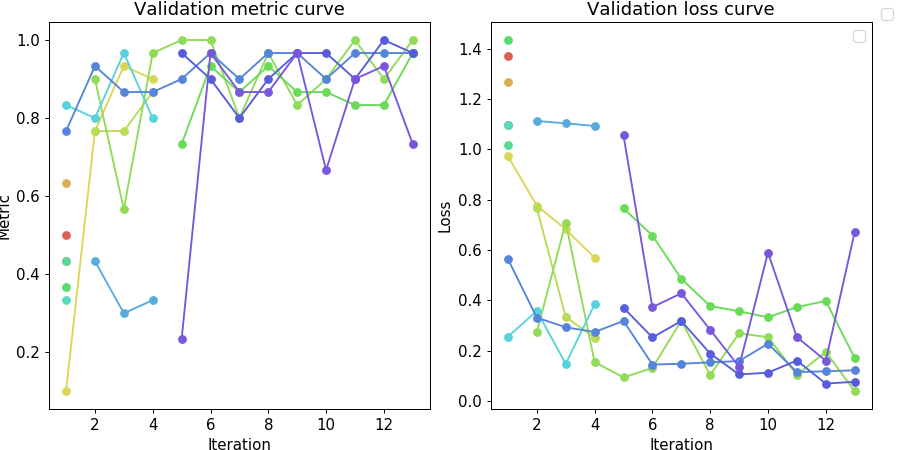

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [21]:
df_results = %sql SELECT * FROM automl_output_info;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM automl_output_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
ax_metric.set_ylabel('Metric')
ax_metric.set_title('Validation metric curve')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Validation loss curve')

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT validation_metrics,validation_loss,metrics_iters FROM automl_output_info WHERE mst_key = $mst_key;
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    iters = df_output_info['metrics_iters'][0]
    
    #ax_metric.plot(iters, validation_metrics, label=mst_key, marker='o')
    ax_metric.plot(iters, validation_metrics, marker='o')
    #ax_loss.plot(iters, validation_loss, label=mst_key, marker='o')
    ax_loss.plot(iters, validation_loss, marker='o')

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

<a id="hyperopt"></a>
# 5.  Hyperopt

In [22]:
%%sql
DROP TABLE IF EXISTS automl_output, automl_output_info, automl_output_summary, automl_mst_table, automl_mst_table_summary;

SELECT madlib.madlib_keras_automl('iris_train_packed',                -- source table
                                  'automl_output',                    -- model output table
                                  'model_arch_library',               -- model architecture table
                                  'automl_mst_table',                 -- model selection output table
                                  ARRAY[1,2],                         -- model IDs
                                  $${
                                      'loss': ['categorical_crossentropy'], 
                                      'optimizer_params_list': [ 
                                          {'optimizer': ['Adam'],'lr': [0.001, 0.1, 'log']},
                                          {'optimizer': ['RMSprop'],'lr': [0.001, 0.1, 'log']}
                                      ],
                                      'metrics': ['accuracy']
                                  } $$,                               -- compile param grid
                                  $${'batch_size': [4, 8], 'epochs': [1]}$$,  -- fit params grid
                                  'hyperopt',                         -- autoML method
                                  'num_configs=20, num_iterations=10, algorithm=tpe',  -- autoML params
                                  NULL,                               -- random state
                                  NULL,                               -- object table
                                  FALSE,                              -- use GPUs
                                  'iris_test_packed',                 -- validation table
                                  1,                                  -- metrics compute freq
                                  NULL,                               -- name
                                  NULL);                              -- descr

Done.
1 rows affected.


madlib_keras_automl
""


View the model summary

In [23]:
%%sql
SELECT * FROM automl_output_summary;

1 rows affected.


source_table,validation_table,model,model_info,dependent_varname,independent_varname,model_arch_table,model_selection_table,automl_method,automl_params,random_state,object_table,use_gpus,metrics_compute_frequency,name,description,start_training_time,end_training_time,madlib_version,num_classes,class_text_class_values,dependent_vartype,normalizing_const
iris_train_packed,iris_test_packed,automl_output,automl_output_info,[u'class_text'],[u'attributes'],model_arch_library,automl_mst_table,hyperopt,"num_configs=20, num_iterations=10, algorithm=tpe",None,None,False,1,None,None,2021-03-05 23:59:31,2021-03-06 00:03:57,1.18.0-dev,[1],"[u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica']",[u'character varying'],1.0


View the results for each model

In [24]:
%%sql
SELECT * FROM automl_output_info ORDER BY validation_metrics_final DESC, validation_loss_final;

20 rows affected.


mst_key,model_id,compile_params,fit_params,model_type,model_size,metrics_elapsed_time,metrics_type,loss_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss,metrics_iters
5,2,"optimizer='RMSprop(lr=0.0084793872639979)',metrics=['accuracy'],loss='categorical_crossentropy'","epochs=1,batch_size=4",madlib_keras,1.18359375,"[56.9403030872345, 59.805566072464, 62.2339789867401, 64.8922078609467, 67.5616340637207, 70.2253429889679, 72.8736228942871, 75.5874469280243, 78.2902030944824, 80.9871909618378]",[u'accuracy'],categorical_crossentropy,0.975000023842,0.0910520926118,"[0.649999976158142, 0.891666650772095, 0.883333325386047, 0.949999988079071, 0.975000023841858, 0.883333325386047, 0.850000023841858, 0.949999988079071, 0.975000023841858, 0.975000023841858]","[0.559232711791992, 0.335382640361786, 0.259929001331329, 0.158979862928391, 0.114544428884983, 0.269487291574478, 0.293675005435944, 0.0902178362011909, 0.0766977593302727, 0.0910520926117897]",0.966666638851,0.0768957436085,"[0.833333313465118, 0.933333337306976, 0.899999976158142, 0.966666638851166, 0.966666638851166, 0.899999976158142, 0.899999976158142, 0.933333337306976, 0.966666638851166, 0.966666638851166]","[0.485892802476883, 0.249617904424667, 0.258282363414764, 0.11016520857811, 0.0912857726216316, 0.280073672533035, 0.178015038371086, 0.087411992251873, 0.062506839632988, 0.0768957436084747]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
14,1,"optimizer='RMSprop(lr=0.03366551083145706)',metrics=['accuracy'],loss='categorical_crossentropy'","epochs=1,batch_size=8",madlib_keras,0.75390625,"[161.690346240997, 164.041937112808, 166.454420089722, 168.906048059464, 171.067217111588, 173.555004119873, 175.944698095322, 178.445127248764, 180.502294063568, 183.037788152695]",[u'accuracy'],categorical_crossentropy,0.949999988079,0.144752591848,"[0.316666662693024, 0.666666686534882, 0.716666638851166, 0.641666650772095, 0.675000011920929, 0.975000023841858, 0.791666686534882, 0.975000023841858, 0.966666638851166, 0.949999988079071]","[1.57745933532715, 0.405172228813171, 0.471270889043808, 1.00022745132446, 0.840015530586243, 0.128021001815796, 0.473532497882843, 0.091586634516716, 0.112696528434753, 0.144752591848373]",0.966666638851,0.100186347961,"[0.433333337306976, 0.666666686534882, 0.899999976158142, 0.766666650772095, 0.866666674613953, 0.966666638851166, 0.899999976158142, 0.933333337306976, 0.966666638851166, 0.966666638851166]","[1.36917245388031, 0.372486144304276, 0.266377687454224, 0.571163833141327, 0.457086622714996, 0.103041857481003, 0.276452839374542, 0.0908508822321892, 0.0997116342186928, 0.100186347961426]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
15,1,"optimizer='Adam(lr=0.009794369846837002)',metrics=['accuracy'],loss='categorical_crossentropy'","epochs=1,batch_size=8",madlib_keras,0.75390625,"[186.611872196198, 188.95641207695, 191.037184238434, 193.397297143936, 195.740861177444, 197.805513143539, 200.180992126465, 202.689172029495, 205.040098190308, 207.208242177963]",[u'accuracy'],categorical_crossentropy,0.949999988079,0.116746708751,"[0.75, 0.975000023841858, 0.850000023841858, 0.941666662693024, 0.933333337306976, 0.949999988079071, 0.949999988079071, 0.983333349227905, 0.958333313465118, 0.949999988079071]","[0.5159512758255, 0.353324204683304, 0.333910763263702, 0.245715036988258, 0.188893154263496, 0.161517903208733, 0.137443989515305, 0.122971840202808, 0.14612153172493, 0.116746708750725]",0.966666638851,0.106192082167,"[0.899999976158142, 0.966666638851166, 0.899999976158142, 0.966666638851166, 0.933333337306976, 0.933333337306976, 0.966666638851166, 0.966666638851166, 0.966666638851166, 0.966666638851166]","[0.423073083162308, 0.298538327217102, 0.234973803162575, 0.176778241991997, 0.170526877045631, 0.145023569464684, 0.119270212948322, 0.103897586464882, 0.104170136153698, 0.106192082166672]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
6,2,"optimizer='Ad

Plot results

20 rows affected.
1 rows affected.


<IPython.core.display.Javascript object>


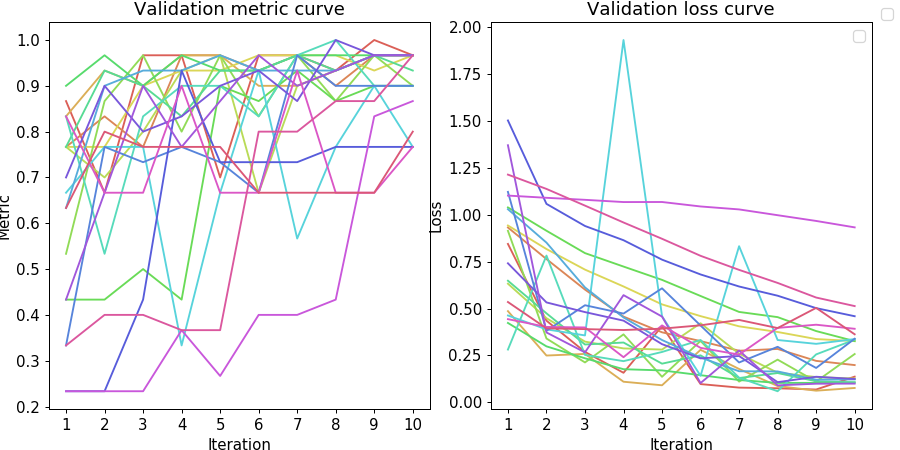

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [25]:
df_results = %sql SELECT * FROM automl_output_info;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM automl_output_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
ax_metric.set_ylabel('Metric')
ax_metric.set_title('Validation metric curve')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Validation loss curve')

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT validation_metrics,validation_loss,metrics_iters FROM automl_output_info WHERE mst_key = $mst_key;
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    iters = df_output_info['metrics_iters'][0]
    
    #ax_metric.plot(iters, validation_metrics, label=mst_key, marker='o')
    ax_metric.plot(iters, validation_metrics)
    #ax_loss.plot(iters, validation_loss, label=mst_key, marker='o')
    ax_loss.plot(iters, validation_loss)

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

Show each trial

20 rows affected.


<IPython.core.display.Javascript object>


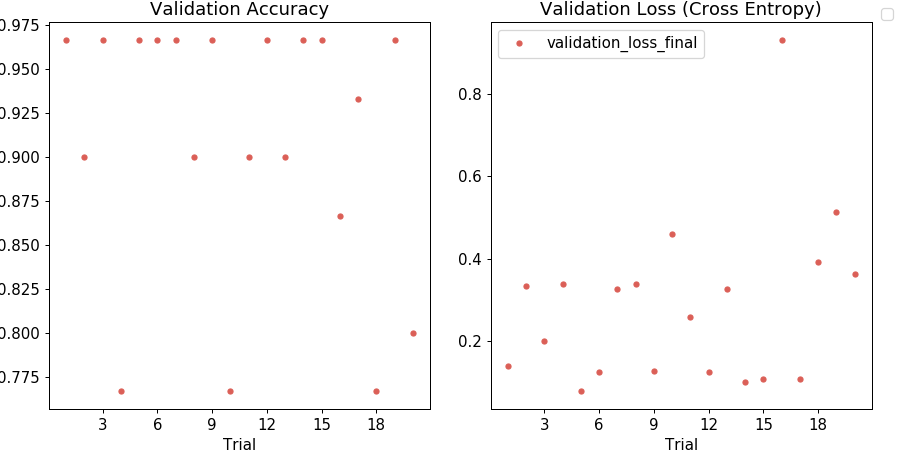

In [26]:
df_results = %sql SELECT * FROM automl_output_info;
df_results = df_results.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Trial')
#ax_metric.set_ylabel('Accuracy')
ax_metric.set_title('Validation Accuracy')
#ax_metric.lines.remove(ax_metric.lines)

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Trial')
#ax_loss.set_ylabel('Cross Entropy Loss')
ax_loss.set_title('Validation Loss (Cross Entropy)')

validation_metrics_final = df_results['validation_metrics_final']
validation_loss_final = df_results['validation_loss_final']
iters = df_results['mst_key']
#iters = [x - (iters[0]-1) for x in iters]

#ax_metric.plot(iters, training_metrics_final, label=mst_key, marker='o')
ax_metric.plot(iters, validation_metrics_final, marker='o', linestyle='None', markersize=4)
#ax_metric.plot(iters, training_metrics)
    
#ax_loss.plot(iters, training_loss_final, label=mst_key, marker='o')
ax_loss.plot(iters, validation_loss_final, marker='o', linestyle='None', markersize=4)
#ax_loss.plot(iters, training_loss)

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

Show best by trial

20 rows affected.
1 rows affected.
2 rows affected.
3 rows affected.
4 rows affected.
5 rows affected.
6 rows affected.
7 rows affected.
8 rows affected.
9 rows affected.
10 rows affected.
11 rows affected.
12 rows affected.
13 rows affected.
14 rows affected.
15 rows affected.
16 rows affected.
17 rows affected.
18 rows affected.
19 rows affected.
20 rows affected.


<IPython.core.display.Javascript object>


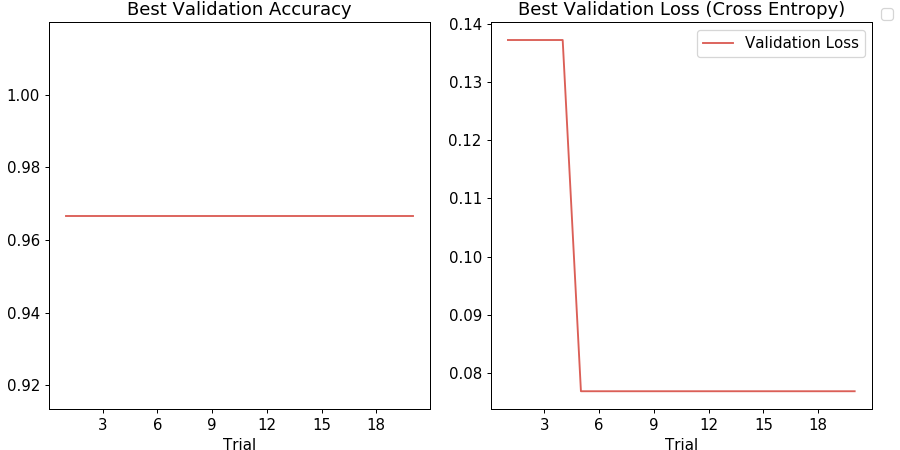

In [27]:
df_results = %sql SELECT * FROM automl_output_info ORDER BY mst_key;
df_results = df_results.DataFrame()

best_so_far_acc = []
best_so_far_loss = []

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT mst_key, validation_metrics_final, validation_loss_final FROM automl_output_info WHERE mst_key <= $mst_key; 
    df_output_info = df_output_info.DataFrame()
    best_so_far_acc.append([mst_key, df_output_info['validation_metrics_final'].max()])
    best_so_far_loss.append([mst_key, df_output_info['validation_loss_final'].min()])

df1 = pd.DataFrame(best_so_far_acc,columns=['Trial','Validation Accuracy'])
df2 = pd.DataFrame(best_so_far_loss,columns=['Trial','Validation Loss'])

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Trial')
#ax_metric.set_ylabel('Accuracy')
ax_metric.set_title('Best Validation Accuracy')
#ax_metric.lines.remove(ax_metric.lines)

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Trial')
#ax_loss.set_ylabel('Cross Entropy Loss')
ax_loss.set_title('Best Validation Loss (Cross Entropy)')

validation_metrics_final = df1['Validation Accuracy']
validation_loss_final = df2['Validation Loss']
iters1 = df1['Trial']
iters2 = df2['Trial']

#ax_metric.plot(iters1, training_metrics_final, label=mst_key, marker='o')
#ax_metric.plot(iters1, validation_metrics_final, marker='o', linestyle='None', markersize=4)
#ax_metric.plot(iters1, validation_metrics_final, marker='o', markersize=0.5)
ax_metric.plot(iters1, validation_metrics_final)
    
#ax_loss.plot(iters2, training_loss_final, label=mst_key, marker='o')
#ax_loss.plot(iters2, validation_loss_final, marker='o', linestyle='None', markersize=4)
ax_loss.plot(iters2, validation_loss_final)

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

<a id="pred"></a>
# 6. Predict

Now predict using model we built.  We will use the validation data set for prediction as well, which is not usual but serves to show the syntax:

In [28]:
%%sql
DROP TABLE IF EXISTS iris_predict;

SELECT madlib.madlib_keras_predict('automl_output',    -- model
                                   'iris_test',        -- test_table
                                   'id',               -- id column
                                   'attributes',       -- independent var
                                   'iris_predict',     -- output table
                                    'response',        -- prediction type
                                    FALSE,             -- use gpus
                                    13                 -- MST key
                                   );

SELECT * FROM iris_predict ORDER BY id;

Done.
1 rows affected.
30 rows affected.


id,class_name,class_value,prob
1,class_text,Iris-setosa,0.77083427
2,class_text,Iris-setosa,0.76736474
3,class_text,Iris-setosa,0.7637215
4,class_text,Iris-setosa,0.76102996
6,class_text,Iris-setosa,0.7710857
7,class_text,Iris-setosa,0.7592268
8,class_text,Iris-setosa,0.7686342
10,class_text,Iris-setosa,0.76880336
18,class_text,Iris-setosa,0.7689748
19,class_text,Iris-setosa,0.77831817


Count missclassifications

In [31]:
%%sql
SELECT COUNT(*) FROM iris_predict JOIN iris_test USING (id) 
WHERE iris_predict.class_value != iris_test.class_text;

1 rows affected.


count
3


Percent missclassifications

In [32]:
%%sql
SELECT round(count(*)*100/(150*0.2),2) as test_accuracy_percent from
    (select iris_test.class_text as actual, iris_predict.class_value as estimated
     from iris_predict inner join iris_test
     on iris_test.id=iris_predict.id) q
WHERE q.actual=q.estimated;

1 rows affected.


test_accuracy_percent
90.00
